# HW02: Classification With Support Vector Machines

Description: https://courses.engr.illinois.edu/cs498aml/sp2019/homeworks/homework2.html

In [138]:
# import the required libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [139]:
def split(data,splitRatio):
    trainSize = int(len(data) * splitRatio)
    np.random.shuffle(data)
    return data[:trainSize,:], data[trainSize:,:]

In [142]:
def normalize(data):
    for i in np.arange(data.shape[1]):
        data[:,i] = (data[:,i] - np.mean(data[:,i]))/np.std(data[:,i])
    return data

In [141]:
def cost(data,a,b,lmbda):
    x,y = data[:,:-1],data[:,-1]
    cost = np.mean(np.maximum(0,1-y*(np.dot(x,a)+b))) + 0.5*lmbda*np.dot(a,a)
    return cost

In [71]:
def gradient(batch,a,b,lmbda):
    a_grad = np.zeros(len(a))
    b_grad = 0
    Nb = len(batch)
    
    for ex in batch:
        x, y = ex[:-1], ex[-1]
        if (y*(np.dot(x,a)+b)) >= 1:
            a_grad += lmbda*a
        else:
            a_grad += lmbda*a - y*x
            b_grad += -step*y
            
    return a_grad/Nb,b_grad/Nb

In [72]:
def pred_svm(x,a,b):
    pred = np.sign(np.dot(x,a)+b)
    return pred

In [73]:
def get_accuracy(true,pred):
    accuracy = sum(true==pred)/len(true)
    return accuracy

In [175]:
def train_svm(data,lmbda=0.1,season=100,steps=426,m=1,n=50,Nb=1):
    a = np.zeros(data.shape[1]-1)
    b = 0
    accuracy = []
    magnitude = []

    for s in range(season):
        step = m/(n+0.01*s)
        train_set, held_out = split(data,1-(50/len(data)))

        for k in range(steps):
            index = np.random.randint(0,len(train_set),Nb)
            batch = train_set[index]
            a_grad, b_grad = gradient(batch,a,b,lmbda)
            a = a - step*a_grad
            b = b - step*b_grad

            if (k+1)%30==0:
                pred = pred_svm(held_out[:,:-1],a,b)
                acc = get_accuracy(held_out[:,-1],pred)
                mag = np.dot(a,a)
                accuracy.append(acc)
                magnitude.append(mag)
                
    return a,b,accuracy,magnitude

In [143]:
train = pd.read_csv('train.txt',sep=',',header=None,usecols=[0,4,10,11,12,14])
train.iloc[:,-1].replace(' <=50K',-1,inplace=True)
train.iloc[:,-1].replace(' >50K',1,inplace=True)
train = train.values.astype(float)

test = pd.read_csv('test.txt',sep=',',header=None,usecols=[0,4,10,11,12]).values.astype(float)

In [144]:
mean = np.mean(train[:,:-1],axis=0)
std = np.std(train[:,:-1],axis=0)

for i in range(len(mean)):
        train[:,i] = (train[:,i] - mean[i])/std[i]
        
for i in range(len(mean)):
        test[:,i] = (test[:,i] - mean[i])/std[i]

In [145]:
train_sub,val = split(train,0.9)

In [189]:
#lmbdas = [1e-4,1e-3,1e-2, 1e-1, 1]
lmbdas = [1e-2,1e-3]
m,n = 1,100
season = 150
steps = 450
Nb = 1
a_all = []
b_all = []
accuracy_all = []
magnitude_all = []

for lmbda in lmbdas:   
    a,b,accuracy,magnitude = train_svm(train_sub,lmbda=lmbda,season=season,steps=steps,m=m,n=n,Nb=Nb)            
    accuracy_all.append(accuracy)
    magnitude_all.append(magnitude)
    a_all.append(a)
    b_all.append(b)
    

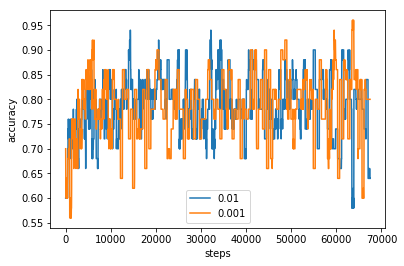

In [190]:
plt.figure(0)
lines=[]
for i in range(len(accuracy_all)):
    line,=plt.plot( np.arange(0,30*len(accuracy),30),accuracy_all[i],label=str(lmbdas[i]))
    lines.append(line)
plt.legend(handles=lines)
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.show()

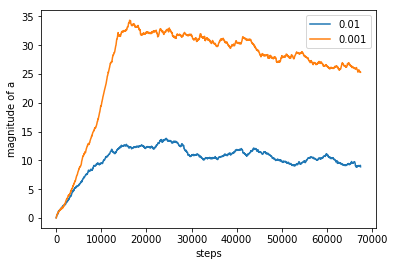

In [191]:
plt.figure(1)
lines=[]
for i in range(len(magnitude_all)):
    line,=plt.plot( np.arange(0,30*len(accuracy),30),magnitude_all[i],label=str(lmbdas[i]))
    lines.append(line)
plt.legend(handles=lines)
plt.ylabel('magnitude of a')
plt.xlabel('steps')
plt.show()

In [194]:
accuracy_list = []
for i in range(len(lmbdas)):
    pred = pred_svm(val[:,:-1],a_all[i],b_all[i])
    acc  = round(get_accuracy(val[:,-1],pred),4)
    accuracy_list.append(acc)
    print('Lambda: {0}\t, Accuracy: {1}\n'.format(lmbdas[i],acc))

Lambda: 0.01	, Accuracy: 0.7903

Lambda: 0.001	, Accuracy: 0.7857



In [196]:
a,b,accuracy,magnitude = train_svm(train,lmbda=0.01,season=150,steps=500,m=m,n=n,Nb=Nb) 

In [198]:
pred = pred_svm(test,a,b).astype(object)
pred[pred==1]=">50K"
pred[pred==-1]="<=50K"
pred.astype(str)
np.savetxt('submission.txt', pred, delimiter='\n', fmt='%s')